In [1]:
import os
import glob
from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import silence_tensorflow.auto
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

E0000 00:00:1738492566.921224  349412 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738492566.927890  349412 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = 1
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.compat.v1.InteractiveSession(config=config)

I0000 00:00:1738492571.126883  349412 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3794 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
H = 256
W = 256
C = 3
h = 8

P = 16     
assert(H == W)
assert(H % P == 0)

D_model = 512 
D_head = 64    
D_fcn = 2048   
num_layers = 4

N = (H * W) // (P * P)
BS = 8

In [4]:
FLOAT = tf.float32

In [15]:
DS_SHAPE = (512,512,3)
def load_and_validate(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=C, expand_animations=False)
    img = tf.divide(tf.cast(img, dtype=FLOAT), 255.0)
    is_valid = tf.reduce_all(tf.equal(tf.shape(img), tf.constant(DS_SHAPE)))

    return img, is_valid


dataset_path = "/mnt/Data/ML/datasets/portraits"
num_samples = 100


all_files = [
    os.path.join(dataset_path, f)
    for f in os.listdir(dataset_path)
    if f.endswith((".jpg", ".png"))
]
random.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)
dataset = dataset.map(load_and_validate)
dataset = dataset.filter(lambda img, is_valid: is_valid)  # Keep valid images
dataset = dataset.map(lambda img, is_valid: img)  # remove unused feature
dataset = dataset.map(lambda img: tf.image.resize(img, (H,W))) 
print(f"Total files: {len(selected_files)}")

with tf.device('/cpu:0'):
    valid_count = dataset.reduce(tf.constant(0, dtype=tf.int32), lambda x, _: x + 1).numpy()

print(f"Valid images count: {valid_count}")
assert valid_count, "Everything's gone"

Total files: 100
Valid images count: 100


In [8]:
def viz_img(img):
    img = tf.cast(img, tf.float32)
    plt.imshow(tf.squeeze(img).numpy(), cmap="gray")
    plt.colorbar()
    plt.show()


def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

def random_visibility_mask():
    x1 = tf.random.uniform(shape=(), minval=0, maxval=W - 100, dtype=tf.int32)
    y1 = tf.random.uniform(shape=(), minval=0, maxval=H - 100, dtype=tf.int32)
    x2 = tf.random.uniform(shape=(), minval=x1 + 50, maxval=W + 1, dtype=tf.int32)
    y2 = tf.random.uniform(shape=(), minval=y1 + 50, maxval=H + 1, dtype=tf.int32)
    # tf.print(x1,x2,y1,y2)

    mask = tf.ones((H, W), dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(
            [
                tf.repeat(tf.range(y1, y2), x2 - x1),
                tf.tile(tf.range(x1, x2), [y2 - y1]),
            ],
            axis=-1,
        ),
        updates=tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.bool),
    )
    return tf.expand_dims(mask, -1)  # expand channel wise


# def mask_area(mask):
#     return tf.reduce_sum(tf.cast(mask, tf.int32))


def extract_patches(image: tf.Tensor) -> tf.Tensor:
    "R^{BS x H x W x C} -> R^{BS x N x P^2 x C}"
    # print(image.dtype)

    patches: tf.Tensor = tf.image.extract_patches(
        images=image,  # Add batch dim
        sizes=[1, P, P, 1],  # Patch size
        strides=[1, P, P, 1],  # Step size
        rates=[1, 1, 1, 1],  # No dilation
        padding="VALID",
    )
    BS, H_prime, W_prime, _ = tf.unstack(tf.shape(patches))

    # Reshape patches to [BS, H' * W', P*P, C]
    patches = tf.reshape(patches, [BS, H_prime * W_prime, P * P, -1])

    return patches


def patches_to_imgs(patches: tf.Tensor) -> tf.Tensor:
    "R^{BS x N x P^2 x C} -> R^{BS x H x W x C}"
    BS = tf.shape(patches)[0]
    grid_size = H // P  # same as W // P

    patches = tf.reshape(patches, [BS, grid_size, grid_size, P, P, C])
    patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])

    image = tf.reshape(patches, [BS, grid_size * P, grid_size * P, C])

    return image


def process_mask(obvmask: tf.Tensor):
    "R^{BS x H x W} -> tuple[R^{BS x N}, R^{BS x N x N}]"
    # TF does not support min pooling. the mask shown here is OBSERVATION MASK meaning 0 means missing. the inpaint mask is a negation of that

    # viz_mask(mask)
    BS = tf.shape(obvmask)[0]
    mask_pooled = tf.nn.max_pool2d(
        tf.cast(
            tf.logical_not(obvmask), dtype=tf.int8
        ),  # insane shit happaned here with mask_inverted
        ksize=[P, P],
        strides=[P, P],
        padding="VALID",
    )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled, tf.bool))
    # viz_mask(mask_pooled)
    mask_pooled = tf.reshape(mask_pooled, [BS, N])
    mask_expanded = tf.expand_dims(mask_pooled, axis=1)  # (BS, 1, N)
    mask_expanded = tf.tile(mask_expanded, [1, N, 1])  # (BS, N, N)
    A = tf.where(
        mask_expanded,
        tf.constant(0.0, dtype=FLOAT),  # zero penanly
        tf.constant(-float("inf"), dtype=FLOAT),  # inf penalty
    )
    # tf.print(tf.shape(A))

    return mask_pooled, A

In [16]:
def prepare_sample(image):
    mask = random_visibility_mask()
    return image, mask


ds_masks = dataset.map(prepare_sample)
train_count = int(valid_count * 0.8)
test_count = int(valid_count * 0.1)
val_count = valid_count - train_count - test_count

train_ds = ds_masks.take(train_count).batch(BS)
test_ds = ds_masks.skip(train_count).take(test_count).batch(BS)
val_ds = ds_masks.skip(train_count + test_count).take(val_count).batch(BS)
print(train_count, test_count,val_count)

80 10 10


In [17]:
class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)  
        self.proj = keras.layers.Dense(D_model, dtype=FLOAT)  # (P² * C) -> D_model

    def build(self, input_shape):
        positions = tf.range(N, dtype=FLOAT)
        positions = tf.expand_dims(positions, 1)  # (N, 1)
        i = tf.range(D_model//2, dtype=FLOAT)
        div_term = tf.exp(
        (2.0 * i) * (-tf.math.log(10000.0) / D_model)
        )
        angles = positions * div_term  # (N, D_model//2)
        sin_terms = tf.sin(angles)
        cos_terms = tf.cos(angles)
            
        self.positional_embedding = tf.reshape(tf.stack([sin_terms, cos_terms], axis=-1), [N, D_model])
        # tf.print(self.positional_embedding)

    def call(self, patches_flat: tf.Tensor):
        # R^{BS x N x (P^2 . C)} -> R^{BS x N x D_model}
        X = self.proj(patches_flat) 
        X += self.positional_embedding 
        return X


class MultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        # Project to h * D_head dimensions
        self.W_Q = keras.layers.Dense(h * D_head, dtype=FLOAT)
        self.W_K = keras.layers.Dense(h * D_head, dtype=FLOAT)
        self.W_V = keras.layers.Dense(h * D_head, dtype=FLOAT)
        # Project back to D_model
        self.W_O = keras.layers.Dense(D_model, dtype=FLOAT)

    def call(self, X, A):
        # X: R^{BS x N x D_model}
        # A: R^{BS x N x N}
        # returns: R^{BS x N x D_model}

        # In the standard implementation, each head has its own separate projection matrices. However, a common optimization is to project the input into h * D_head dimensions (which is D_model) with a single large projection, then split into h heads. So, if D_model = h * D_head, then using a Dense(D_model) for Q, K, V and then splitting into h heads each of D_head is equivalent to having h separate projections. This is a standard approach because it's more efficient to compute all heads in parallel with a single matrix multiplication rather than h separate ones.
        # So the optimal way is to use combined projections.
        Q = self.W_Q(X)  # (BS, N, h * D_head)
        K = self.W_K(X)  # (BS, N, h * D_head)
        V = self.W_V(X)  # (BS, N, h * D_head)
        

        Q = tf.reshape(Q, (-1, N, h, D_head))  # (BS, N, h, D_head)
        K = tf.reshape(K, (-1, N, h, D_head))
        V = tf.reshape(V, (-1, N, h, D_head))

        # Transpose for attention computation
        Q = tf.transpose(Q, [0, 2, 1, 3])  # (BS, h, N, D_head)
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])
        # scaled dot-product attention
        attn_scores = tf.matmul(Q, K, transpose_b=True)  # (BS, h, N, N)
        attn_scores /= tf.math.sqrt(
            tf.cast(D_head, attn_scores.dtype)
        )  # scale by sqrt(D_head)

        A = tf.expand_dims(A, 1)  # (BS, 1, N, N)
        attn_scores += A  # Broadcast to all heads

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)  # (BS, h, N, N)

        output = tf.matmul(attn_weights, V)  # (BS, h, N, D_head)
        output = tf.transpose(output, [0, 2, 1, 3])  # (BS, N, h, D_head)
        output = tf.reshape(output, (-1, N, h * D_head))  # (BS, N, h * D_head)
        output = self.W_O(output)  # (BS, N, D_model)
        return output


class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.attn = MultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.norm2 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(D_fcn, activation="gelu", dtype=FLOAT),
                keras.layers.Dense(D_model, dtype=FLOAT),
                # keras.layers.Dropout(0.1, dtype=FLOAT),
            ],
        )

    def call(self, X, A):
        "R^{N x D_model} -> R^{N x D_model}"
        X = self.norm1(X + self.attn(X, A))
        X = self.norm2(X + self.ffn(X))
        return X


class Decoder(keras.layers.Layer):
    def __init__(self, patch_size=P, channels=C, hidden_dim=D_model):
        super().__init__(dtype=FLOAT)
        self.mlp = keras.Sequential([
            keras.layers.Dense(hidden_dim * 2, activation="gelu", dtype=FLOAT),
            keras.layers.Dense(patch_size * patch_size * channels, dtype=FLOAT),
        ])

    def call(self, X):
        # X: R^{BS x N x D_model}
        BS = tf.shape(X)[0]
        X = self.mlp(X)  # (BS, N, patch_size^2 * channels)
        X = tf.reshape(X, (BS, N, P, P, C))
        return X


class ImageInpaintingTransformer(keras.Model):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = Decoder()

    def build(self, input_shape):
        BS = input_shape[0]
        # dummy_images = tf.zeros((BS, H, W, C), dtype=FLOAT)  # THIS WASTED 40 MINUTES
        self.call(*next(iter(val_ds.take(1))))
        self.built = True

    def call(self, image, obvmask):
        image = tf.multiply(image, tf.cast(obvmask,FLOAT))
        # viz_img(image[0])
        patches = extract_patches(image)
        mask_pooled, A = process_mask(obvmask)
        # tf.print(tf.shape(A))
        # viz_img(A)

        BS = tf.shape(patches)[0]
        patches_flat = tf.reshape(patches, [BS, N, P**2 * C])
        # tf.print(tf.shape(patches_flat))
        X = self.embed(patches_flat)
        for block in self.transformer_blocks:
            X = block(X, A)
        reconstructed_patches = self.decoder(X)  # R^{BS x N x P x P x C}
        return patches_to_imgs(reconstructed_patches)

model = ImageInpaintingTransformer()
model.build((BS, H, W, C))
model.summary()

Model: "image_inpainting_transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding_1               │ ?                      │       393,728 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │     1,312,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,315,776 (54.61 MB)

 Trainable params: 14,315,776 (54.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# # Tests patching and depatching

# img = next(iter(dataset.take(1)))

# viz_img(img)
# patched = extract_patches(tf.expand_dims(img ,0))
# tf.print(tf.shape(patched))

# recreated_img = patches_to_imgs(patched)
# viz_img(recreated_img)

In [19]:
# @tf.function
# def costfunc(y_true: tf.Tensor, y_pred: tf.Tensor, obsvmask: tf.Tensor):
#     absolute_errors = tf.abs(tf.subtract(y_true, y_pred))

#     unmasked_loss = 0.1 * tf.reduce_mean(absolute_errors * tf.cast(obsvmask, FLOAT))
    
#     inpaintmask = tf.cast(tf.logical_not(obsvmask), FLOAT)
#     masked_errors = tf.multiply(absolute_errors, inpaintmask)
#     sum_masked_errors = tf.reduce_sum(masked_errors)
#     area = tf.reduce_sum(inpaintmask)
#     return (sum_masked_errors / (area + keras.backend.epsilon())) + unmasked_loss

@tf.function
def costfunc(y_true: tf.Tensor, y_pred: tf.Tensor, obsvmask: tf.Tensor):
    absolute_errors = tf.abs(tf.subtract(y_true, y_pred))

    unmasked_loss = 0.1 * tf.reduce_mean(absolute_errors * tf.cast(obsvmask, FLOAT))
    
    inpaintmask = tf.cast(tf.logical_not(obsvmask), FLOAT)
    masked_errors = tf.multiply(absolute_errors, inpaintmask)
    sum_masked_errors = tf.reduce_sum(masked_errors)
    area = tf.reduce_sum(inpaintmask)
    return (sum_masked_errors / (area + keras.backend.epsilon())) + unmasked_loss


optimizer = keras.optimizers.Adam(learning_rate=1e-5)

@tf.function
def train_step(image: tf.Tensor, mask: tf.Tensor):
    with tf.GradientTape() as tape:
        reconstructed_img = model(image, mask)  # N x P x P x C
        loss = costfunc(image, reconstructed_img, mask)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


@tf.function
def val_step(image: tf.Tensor, mask: tf.Tensor):
    reconstructed_img = model(image, mask, training = False)
    loss = costfunc(image, reconstructed_img, mask)
    return loss


epochs = 50
print("Starting training")
for epoch in range(epochs):
    epoch_loss = 0.0
    steps = 0
    pbar = tqdm(train_ds, desc=f"Epoch {epoch+1}", unit="batch", total=train_count // BS)
    for image_batch, mask_batch in pbar:
        loss = train_step(image_batch, mask_batch)
        epoch_loss += loss
        steps += 1
        # Dynamically update the tqdm bar without spamming stdout
        pbar.set_postfix(loss=f"{loss:.4f}")
    train_loss = epoch_loss / steps

    val_loss_total = 0.0
    val_steps = 0
    pbar_val = tqdm(val_ds, desc=f"Epoch {epoch+1} Validation", unit="batch", total=val_count // BS)
    for val_image_batch, val_mask_batch in pbar_val:
        loss = val_step(val_image_batch, val_mask_batch)
        val_loss_total += loss
        val_steps += 1
        pbar_val.set_postfix(loss=f"{loss:.4f}")
    avg_val_loss = val_loss_total / val_steps

    print(f"Epoch {epoch+1} Summary: Train Loss = {train_loss:.4f} | Validation Loss = {avg_val_loss:.4f}")


Starting training


Epoch 1: 100%|██████████| 10/10 [00:11<00:00,  1.16s/batch, loss=0.8940]
Epoch 1 Validation: 2batch [00:01,  1.38batch/s, loss=0.8111]                    


Epoch 1 Summary: Train Loss = 0.9449 | Validation Loss = 0.8360


Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  8.37batch/s, loss=1.0009]
Epoch 2 Validation: 2batch [00:00,  8.23batch/s, loss=0.7843]                    


Epoch 2 Summary: Train Loss = 0.9268 | Validation Loss = 0.8407


Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  8.42batch/s, loss=0.8752]
Epoch 3 Validation: 2batch [00:00,  8.32batch/s, loss=0.6726]                    


Epoch 3 Summary: Train Loss = 0.9071 | Validation Loss = 0.7786


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  8.60batch/s, loss=0.8389]
Epoch 4 Validation: 2batch [00:00,  7.68batch/s, loss=0.6979]                    


Epoch 4 Summary: Train Loss = 0.8697 | Validation Loss = 0.7474


Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  8.45batch/s, loss=0.8138]
Epoch 5 Validation: 2batch [00:00,  7.76batch/s, loss=0.6283]                    


Epoch 5 Summary: Train Loss = 0.8412 | Validation Loss = 0.7355


Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  8.31batch/s, loss=0.7632]
Epoch 6 Validation: 2batch [00:00,  7.71batch/s, loss=0.6963]                    


Epoch 6 Summary: Train Loss = 0.8157 | Validation Loss = 0.7574


Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  8.28batch/s, loss=0.7801]
Epoch 7 Validation: 2batch [00:00,  7.75batch/s, loss=0.7276]                    


Epoch 7 Summary: Train Loss = 0.7989 | Validation Loss = 0.7519


Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  8.40batch/s, loss=0.8403]
Epoch 8 Validation: 2batch [00:00,  7.42batch/s, loss=0.6345]                    


Epoch 8 Summary: Train Loss = 0.7816 | Validation Loss = 0.7070


Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  8.33batch/s, loss=0.7829]
Epoch 9 Validation: 2batch [00:00,  7.66batch/s, loss=0.6171]                    


Epoch 9 Summary: Train Loss = 0.7903 | Validation Loss = 0.6520


Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  8.37batch/s, loss=0.7482]
Epoch 10 Validation: 2batch [00:00,  7.62batch/s, loss=0.5727]                    


Epoch 10 Summary: Train Loss = 0.8044 | Validation Loss = 0.6587


Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  8.31batch/s, loss=0.7195]
Epoch 11 Validation: 2batch [00:00,  7.55batch/s, loss=0.5892]                    


Epoch 11 Summary: Train Loss = 0.7782 | Validation Loss = 0.6580


Epoch 12: 100%|██████████| 10/10 [00:01<00:00,  8.34batch/s, loss=0.7247]
Epoch 12 Validation: 2batch [00:00,  7.10batch/s, loss=0.6609]                    


Epoch 12 Summary: Train Loss = 0.7552 | Validation Loss = 0.6916


Epoch 13: 100%|██████████| 10/10 [00:01<00:00,  8.21batch/s, loss=0.7887]
Epoch 13 Validation: 2batch [00:00,  7.62batch/s, loss=0.5466]                    


Epoch 13 Summary: Train Loss = 0.7824 | Validation Loss = 0.6097


Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  8.33batch/s, loss=0.7613]
Epoch 14 Validation: 2batch [00:00,  7.44batch/s, loss=0.8133]                    


Epoch 14 Summary: Train Loss = 0.7465 | Validation Loss = 0.7556


Epoch 15: 100%|██████████| 10/10 [00:01<00:00,  8.28batch/s, loss=0.7663]
Epoch 15 Validation: 2batch [00:00,  7.53batch/s, loss=0.5931]                    


Epoch 15 Summary: Train Loss = 0.7539 | Validation Loss = 0.6527


Epoch 16: 100%|██████████| 10/10 [00:01<00:00,  8.29batch/s, loss=0.7750]
Epoch 16 Validation: 2batch [00:00,  7.46batch/s, loss=0.6074]                    


Epoch 16 Summary: Train Loss = 0.7577 | Validation Loss = 0.6893


Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  8.37batch/s, loss=0.7809]
Epoch 17 Validation: 2batch [00:00,  7.57batch/s, loss=0.6140]                    


Epoch 17 Summary: Train Loss = 0.7319 | Validation Loss = 0.6503


Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  8.37batch/s, loss=0.7411]
Epoch 18 Validation: 2batch [00:00,  7.64batch/s, loss=0.6246]                    


Epoch 18 Summary: Train Loss = 0.7486 | Validation Loss = 0.6619


Epoch 19: 100%|██████████| 10/10 [00:01<00:00,  8.19batch/s, loss=0.7544]
Epoch 19 Validation: 2batch [00:00,  7.60batch/s, loss=0.5804]                    


Epoch 19 Summary: Train Loss = 0.7479 | Validation Loss = 0.6495


Epoch 20: 100%|██████████| 10/10 [00:01<00:00,  8.09batch/s, loss=0.7738]
Epoch 20 Validation: 2batch [00:00,  7.67batch/s, loss=0.5963]                    


Epoch 20 Summary: Train Loss = 0.7376 | Validation Loss = 0.6209


Epoch 21: 100%|██████████| 10/10 [00:01<00:00,  8.46batch/s, loss=0.7564]
Epoch 21 Validation: 2batch [00:00,  7.53batch/s, loss=0.6981]                    


Epoch 21 Summary: Train Loss = 0.7541 | Validation Loss = 0.7791


Epoch 22: 100%|██████████| 10/10 [00:01<00:00,  8.03batch/s, loss=0.7249]
Epoch 22 Validation: 2batch [00:00,  7.42batch/s, loss=0.6197]                    


Epoch 22 Summary: Train Loss = 0.7531 | Validation Loss = 0.8356


Epoch 23: 100%|██████████| 10/10 [00:01<00:00,  8.32batch/s, loss=0.7250]
Epoch 23 Validation: 2batch [00:00,  7.51batch/s, loss=0.6446]                    


Epoch 23 Summary: Train Loss = 0.7268 | Validation Loss = 0.6427


Epoch 24: 100%|██████████| 10/10 [00:01<00:00,  8.46batch/s, loss=0.8059]
Epoch 24 Validation: 2batch [00:00,  7.47batch/s, loss=0.7230]                    


Epoch 24 Summary: Train Loss = 0.7391 | Validation Loss = 0.7173


Epoch 25: 100%|██████████| 10/10 [00:01<00:00,  8.36batch/s, loss=0.7011]
Epoch 25 Validation: 2batch [00:00,  7.39batch/s, loss=0.6418]                    


Epoch 25 Summary: Train Loss = 0.7391 | Validation Loss = 0.6791


Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  8.27batch/s, loss=0.7320]
Epoch 26 Validation: 2batch [00:00,  7.57batch/s, loss=0.5745]                    


Epoch 26 Summary: Train Loss = 0.7430 | Validation Loss = 0.6333


Epoch 27: 100%|██████████| 10/10 [00:01<00:00,  8.27batch/s, loss=0.7254]
Epoch 27 Validation: 2batch [00:00,  7.47batch/s, loss=0.5988]                    


Epoch 27 Summary: Train Loss = 0.7379 | Validation Loss = 0.7000


Epoch 28: 100%|██████████| 10/10 [00:01<00:00,  8.47batch/s, loss=0.7993]
Epoch 28 Validation: 2batch [00:00,  7.67batch/s, loss=0.6311]                    


Epoch 28 Summary: Train Loss = 0.7457 | Validation Loss = 0.7095


Epoch 29: 100%|██████████| 10/10 [00:01<00:00,  8.25batch/s, loss=0.6983]
Epoch 29 Validation: 2batch [00:00,  7.08batch/s, loss=0.5810]                    


Epoch 29 Summary: Train Loss = 0.7119 | Validation Loss = 0.6401


Epoch 30: 100%|██████████| 10/10 [00:01<00:00,  8.29batch/s, loss=0.6544]
Epoch 30 Validation: 2batch [00:00,  7.48batch/s, loss=0.6207]                    


Epoch 30 Summary: Train Loss = 0.7203 | Validation Loss = 0.6820


Epoch 31: 100%|██████████| 10/10 [00:01<00:00,  8.23batch/s, loss=0.6745]
Epoch 31 Validation: 2batch [00:00,  6.30batch/s, loss=0.4797]                    


Epoch 31 Summary: Train Loss = 0.7136 | Validation Loss = 0.5886


Epoch 32: 100%|██████████| 10/10 [00:01<00:00,  8.29batch/s, loss=0.7123]
Epoch 32 Validation: 2batch [00:00,  7.58batch/s, loss=0.7359]                    


Epoch 32 Summary: Train Loss = 0.7407 | Validation Loss = 0.6938


Epoch 33: 100%|██████████| 10/10 [00:01<00:00,  8.36batch/s, loss=0.7781]
Epoch 33 Validation: 2batch [00:00,  7.70batch/s, loss=0.7396]                    


Epoch 33 Summary: Train Loss = 0.7451 | Validation Loss = 0.6970


Epoch 34: 100%|██████████| 10/10 [00:01<00:00,  8.42batch/s, loss=0.7172]
Epoch 34 Validation: 2batch [00:00,  7.35batch/s, loss=0.7234]                    


Epoch 34 Summary: Train Loss = 0.7071 | Validation Loss = 0.6922


Epoch 35: 100%|██████████| 10/10 [00:01<00:00,  8.37batch/s, loss=0.7029]
Epoch 35 Validation: 2batch [00:00,  6.93batch/s, loss=0.6142]                    


Epoch 35 Summary: Train Loss = 0.6974 | Validation Loss = 0.6881


Epoch 36: 100%|██████████| 10/10 [00:01<00:00,  7.90batch/s, loss=0.7229]
Epoch 36 Validation: 2batch [00:00,  7.80batch/s, loss=0.5557]                    


Epoch 36 Summary: Train Loss = 0.7223 | Validation Loss = 0.6254


Epoch 37: 100%|██████████| 10/10 [00:01<00:00,  8.16batch/s, loss=0.6633]
Epoch 37 Validation: 2batch [00:00,  7.76batch/s, loss=0.5432]                    


Epoch 37 Summary: Train Loss = 0.7047 | Validation Loss = 0.6392


Epoch 38: 100%|██████████| 10/10 [00:01<00:00,  8.12batch/s, loss=0.7607]
Epoch 38 Validation: 2batch [00:00,  6.97batch/s, loss=0.5922]                    


Epoch 38 Summary: Train Loss = 0.7296 | Validation Loss = 0.6426


Epoch 39: 100%|██████████| 10/10 [00:01<00:00,  8.26batch/s, loss=0.6803]
Epoch 39 Validation: 2batch [00:00,  7.05batch/s, loss=0.4827]                    


Epoch 39 Summary: Train Loss = 0.7134 | Validation Loss = 0.6327


Epoch 40: 100%|██████████| 10/10 [00:01<00:00,  8.34batch/s, loss=0.6680]
Epoch 40 Validation: 2batch [00:00,  7.38batch/s, loss=0.4896]                    


Epoch 40 Summary: Train Loss = 0.7023 | Validation Loss = 0.5685


Epoch 41: 100%|██████████| 10/10 [00:01<00:00,  8.34batch/s, loss=0.6996]
Epoch 41 Validation: 2batch [00:00,  7.77batch/s, loss=0.5356]                    


Epoch 41 Summary: Train Loss = 0.7289 | Validation Loss = 0.6333


Epoch 42: 100%|██████████| 10/10 [00:01<00:00,  8.27batch/s, loss=0.7139]
Epoch 42 Validation: 2batch [00:00,  7.40batch/s, loss=0.5596]                    


Epoch 42 Summary: Train Loss = 0.7160 | Validation Loss = 0.6028


Epoch 43: 100%|██████████| 10/10 [00:01<00:00,  8.25batch/s, loss=0.6900]
Epoch 43 Validation: 2batch [00:00,  7.67batch/s, loss=0.6077]                    


Epoch 43 Summary: Train Loss = 0.7093 | Validation Loss = 0.6682


Epoch 44: 100%|██████████| 10/10 [00:01<00:00,  8.41batch/s, loss=0.6921]
Epoch 44 Validation: 2batch [00:00,  7.76batch/s, loss=0.6886]                    


Epoch 44 Summary: Train Loss = 0.7340 | Validation Loss = 0.6382


Epoch 45: 100%|██████████| 10/10 [00:01<00:00,  8.18batch/s, loss=0.6971]
Epoch 45 Validation: 2batch [00:00,  7.59batch/s, loss=0.6245]                    


Epoch 45 Summary: Train Loss = 0.7006 | Validation Loss = 0.6477


Epoch 46: 100%|██████████| 10/10 [00:01<00:00,  8.22batch/s, loss=0.7227]
Epoch 46 Validation: 2batch [00:00,  7.78batch/s, loss=0.5679]                    


Epoch 46 Summary: Train Loss = 0.6814 | Validation Loss = 0.6265


Epoch 47: 100%|██████████| 10/10 [00:01<00:00,  8.33batch/s, loss=0.6653]
Epoch 47 Validation: 2batch [00:00,  7.71batch/s, loss=0.5288]                    


Epoch 47 Summary: Train Loss = 0.6996 | Validation Loss = 0.5879


Epoch 48: 100%|██████████| 10/10 [00:01<00:00,  8.14batch/s, loss=0.6654]
Epoch 48 Validation: 2batch [00:00,  7.50batch/s, loss=0.5372]                    


Epoch 48 Summary: Train Loss = 0.7022 | Validation Loss = 0.5493


Epoch 49: 100%|██████████| 10/10 [00:01<00:00,  8.38batch/s, loss=0.6627]
Epoch 49 Validation: 2batch [00:00,  7.74batch/s, loss=0.5785]                    


Epoch 49 Summary: Train Loss = 0.7119 | Validation Loss = 0.6639


Epoch 50: 100%|██████████| 10/10 [00:01<00:00,  8.48batch/s, loss=0.7242]
Epoch 50 Validation: 2batch [00:00,  7.86batch/s, loss=0.5905]                    

Epoch 50 Summary: Train Loss = 0.7121 | Validation Loss = 0.7048


In [11]:
model.save("b4.keras")

In [20]:
def apply_obsv_mask(image: tf.Tensor, obvmask: tf.Tensor) -> tf.Tensor:
    return tf.multiply(image, tf.cast(obvmask, FLOAT))


def viz_grid(batch: tf.Tensor):
    batch_size: int = batch.shape[0]  # type: ignore
    fig, axes = plt.subplots(nrows=1, ncols=batch_size, figsize=(15, 15))
    if batch_size == 1:
        axes = [axes]
    for i in range(batch_size):
        # Original image
        axes[i].imshow(tf.cast(batch[i], dtype=tf.float32).numpy())  # type: ignore
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


def reconstruct(original: tf.Tensor, reconstruct: tf.Tensor, obvmask: tf.Tensor):
    return tf.add(
        tf.multiply(tf.cast(obvmask, FLOAT), original),
        tf.multiply(tf.cast(tf.logical_not(obvmask), FLOAT), reconstruct),
    )

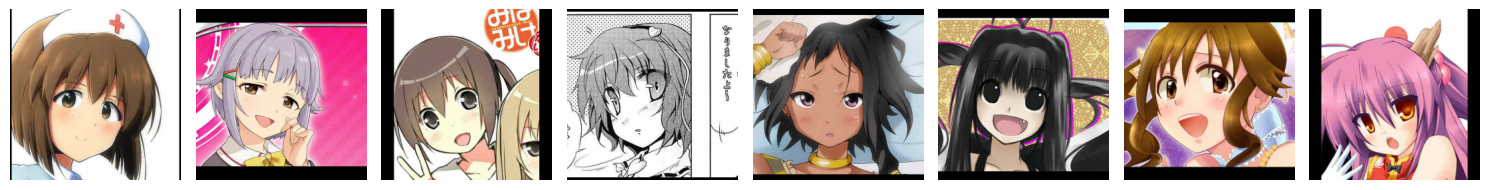

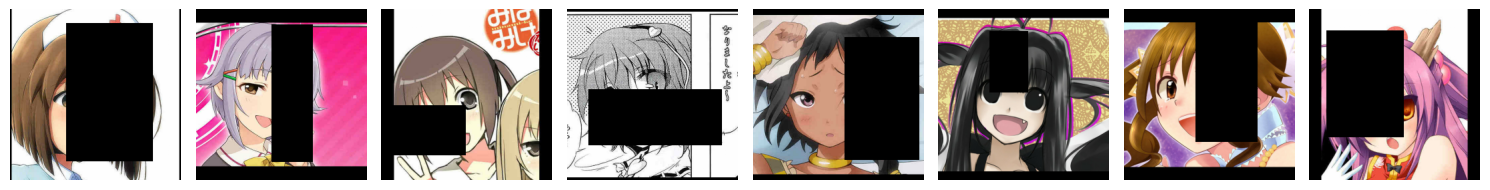

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.19965352..1.0268943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.22629264..1.0999082].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18528916..1.0525457].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.40183488..1.071304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15274929..1.0081565].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14670157..1.0254757].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12592362

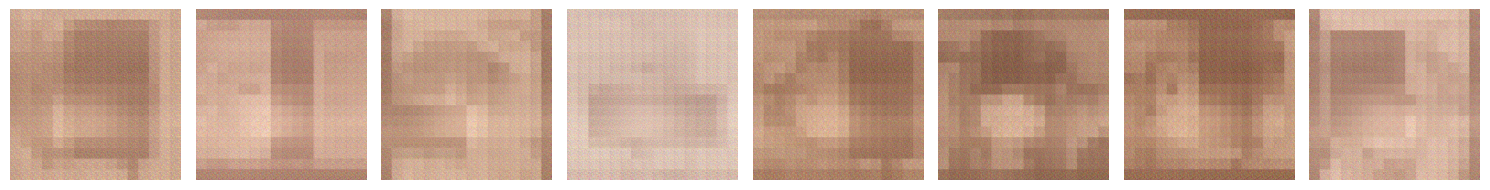

In [21]:
# Qualitative Eval
# visualize_unbatched_dataset(test_ds, 5)


# img = tf.image.decode_image(
#     tf.io.read_file("/home/navid/Dev/PaperTex/impl/naruto")
#     , dtype=tf.float32)
# img = tf.image.resize_with_crop_or_pad(img, H, W)
# img = tf.expand_dims(img, 0)
# tf.print(tf.shape(img))
# obvmask = tf.expand_dims(random_visibility_mask(),0)
# tf.print(tf.shape(obvmask))


img, obvmask = next(iter(test_ds.take(1)))
viz_grid(img)
viz_grid(apply_obsv_mask(img, obvmask))
model_out = model(img, obvmask)
# reconstructed = reconstruct(img, model(img, obvmask), obvmask)
viz_grid(model_out)

In [ ]:
print(tf.reduce_mean(tf.square(tf.subtract(model_out[0],img[0]))).numpy())

viz_img(model_out[0])
viz_img(img[0]) 